In [1]:
from os import environ as ENV
ROOT = ENV['PWD']
DATA = ROOT + '/data/'
FIGS = ROOT + '/figures/'

In [2]:
import os

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid

import numpy as np
import numpy.typing as npt

In [3]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

# data loading

In [4]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons] # .apply(lambda x: rescale(x, np.pi/2), axis=1)
coords = get_coords(record).loc[sig_neurons]

In [5]:
corrs_df = tuning_curves.T.corr()
corrs_df.to_csv(DATA + 'classical-correlations.csv')
corrs_df

,23,32,35,36,37,50,53,55,57,59,...,411,416,419,420,421,424,425,426,428,435
23,1.000000,-0.489674,0.661540,0.206720,0.604894,0.738459,0.840655,0.842762,0.819609,0.420833,...,0.597267,0.295981,0.410455,0.185429,0.693904,0.720026,0.825029,0.455308,0.632510,0.308969
32,-0.489674,1.000000,-0.596449,0.086894,0.181528,-0.048669,-0.353843,-0.170236,-0.154536,-0.066270,...,0.215513,0.266487,0.337279,0.143623,-0.130767,-0.093222,-0.280509,0.035892,-0.390656,0.068023
35,0.661540,-0.596449,1.000000,0.036591,0.253894,0.699936,0.753505,0.719987,0.710097,0.525593,...,0.190534,0.284538,0.420381,0.136743,0.529959,0.492206,0.831712,0.002947,0.405079,0.171913
36,0.206720,0.086894,0.036591,1.000000,0.182721,0.057567,0.386210,0.156337,0.045494,0.075295,...,0.109216,0.202316,0.410737,0.039800,-0.179925,0.310371,0.169477,0.044842,-0.231750,0.446474
37,0.604894,0.181528,0.253894,0.182721,1.000000,0.775998,0.728235,0.696522,0.823081,0.659072,...,0.733332,0.756497,0.570538,0.392736,0.773308,0.599689,0.639477,0.604168,0.536870,0.714616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.720026,-0.093222,0.492206,0.310371,0.599689,0.806530,0.655613,0.837230,0.692688,0.194146,...,0.761772,0.116137,0.358099,-0.163071,0.483677,1.000000,0.629357,0.777114,0.077318,0.307842
425,0.825029,-0.280509,0.831712,0.169477,0.639477,0.884600,0.892171,0.853809,0.942081,0.748289,...,0.582319,0.614619,0.717722,0.333818,0.754016,0.629357,1.000000,0.190794,0.596609,0.471784
426,0.455308,0.035892,0.002947,0.044842,0.604168,0.510365,0.327662,0.500403,0.410597,0.003023,...,0.680641,-0.034927,-0.094314,-0.229323,0.349806,0.777114,0.190794,1.000000,0.039779,0.304123
428,0.632510,-0.390656,0.405079,-0.231750,0.536870,0.403937,0.521279,0.387531,0.652936,0.561446,...,0.372136,0.521788,0.283315,0.315866,0.825566,0.077318,0.596609,0.039779,1.000000,0.318983


In [6]:
qf_matrix = {
    k: pd.read_csv(DATA + f'results_simulator_{k}.csv', index_col=0)
    for k in ['ang', 'ang-qft', 'amp', 'amp-qft']
}

In [8]:
# load and reconstruct the distance matrices from the qpus
qpu_results_df = pd.read_excel(DATA + 'results_ibm-kingston.xlsx', index_col=0)

# make fully symmetric matrix
for i in range(len(qpu_results_df)):
    row = qpu_results_df.loc[i]
    if row['A'] != row['B']:
        new_row = row.copy()
        new_row['B'] = row['A']
        new_row['A'] = row['B']
        qpu_results_df.loc[len(qpu_results_df)] = new_row

In [10]:
# invert fidelities as a fidelity of 1 = "same" and 0 = "different"
qpu_ang, qpu_amp_qft, qpu_amp_qft_ddd, qpu_amp, qpu_amd_ddd = [
    1 - qpu_results_df.pivot_table(index = 'A', columns = 'B')[col].astype(np.float64)
    for col in ['ang', 'amp-qft', 'amp-qft-ddd', 'amp', 'amp-ddd']
]

In [11]:
rescaled_tuning_curves = pd.read_csv(DATA + 'data_tuning-curves_rescaled.csv', index_col=0)
resampled_tuning_curves = pd.read_csv(DATA + 'data_tuning-curves_resampled.csv', index_col=0)

In [12]:
from scipy.fft import ifft
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

def fidelity(a,b):
    ra = a / np.linalg.norm(a, ord=1)
    rb = b / np.linalg.norm(a, ord=1)
    return np.sum(np.sqrt(ra*rb)) ** 2

euclidean_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean', 'euclidean_ifft', 'classical_fidelity'])

 # A x B
pairs, pairs_len = combinations(rescaled_tuning_curves.index, 2), (len(rescaled_tuning_curves) * (len(rescaled_tuning_curves) - 1) // 2)
for a, b in pairs:
    a_i, b_i = rescaled_tuning_curves.loc[a], rescaled_tuning_curves.loc[b]
    a_i_resampled, b_i_resampled = resampled_tuning_curves.loc[a], resampled_tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    dist_ifft = euclidean(ifft(a_i_resampled), ifft(b_i_resampled))
    classical_fidelity = fidelity(a_i, b_i)
    # print(dist)
    euclidean_distance.loc[len(euclidean_distance)] = [a, b, dist, dist_ifft, classical_fidelity]
    euclidean_distance.loc[len(euclidean_distance)] = [b, a, dist, dist_ifft, classical_fidelity]

# # A x A
# # for sanity checking
for a in rescaled_tuning_curves.index:
    a_i = rescaled_tuning_curves.loc[a]
    a_i_resampled = resampled_tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    dist_ifft = euclidean(ifft(a_i), ifft(a_i))
    classical_fidelity = fidelity(a_i, a_i)
    euclidean_distance.loc[len(euclidean_distance)] = [a, a, dist, dist_ifft, classical_fidelity]


In [13]:
# turn into symmetric matrices
euclidean_distance_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean'].astype(np.float64)
euclidean_distance_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,0.732914,0.233373,0.376584,0.250854,0.210692,0.185061,0.172488,0.198512,0.282613,...,0.253264,0.314650,0.385392,0.383556,0.509887,0.431631,0.176818,0.284447,0.242550,0.302799
32.0,0.732914,0.000000,0.665136,0.578849,0.536400,0.595732,0.618616,0.652946,0.672797,0.558283,...,0.516963,0.512473,0.540280,0.565058,0.909246,0.834051,0.637110,0.560685,0.614181,0.542025
35.0,0.233373,0.665136,0.000000,0.341400,0.260809,0.179981,0.134466,0.211872,0.245494,0.173298,...,0.219627,0.234896,0.354210,0.327074,0.593495,0.529323,0.131582,0.285121,0.200582,0.231925
36.0,0.376584,0.578849,0.341400,0.000000,0.331815,0.369095,0.274211,0.383344,0.436164,0.312081,...,0.305188,0.312364,0.376256,0.398873,0.778080,0.577054,0.339235,0.345477,0.364013,0.258222
37.0,0.250854,0.536400,0.260809,0.331815,0.000000,0.161407,0.157469,0.218539,0.201740,0.171620,...,0.157216,0.151016,0.319231,0.289782,0.518039,0.495743,0.197658,0.194446,0.197849,0.159622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.431631,0.834051,0.529323,0.577054,0.495743,0.422691,0.496607,0.381511,0.437008,0.587213,...,0.498264,0.606985,0.584753,0.705332,0.649415,0.000000,0.484905,0.455995,0.608291,0.569163
425.0,0.176818,0.637110,0.131582,0.339235,0.197658,0.117708,0.110334,0.159658,0.143231,0.159956,...,0.192705,0.193559,0.273840,0.306849,0.519069,0.484905,0.000000,0.283242,0.192077,0.214668
426.0,0.284447,0.560685,0.285121,0.345477,0.194446,0.229199,0.227707,0.268582,0.319164,0.253846,...,0.151496,0.289709,0.457107,0.392432,0.631964,0.455995,0.283242,0.000000,0.261310,0.220057


In [14]:
euclidean_distance_df.to_csv(DATA + 'euclidean_distance.csv')

In [15]:
euclidean_distance_ifft_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean_ifft'].astype(np.float64)
euclidean_distance_ifft_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,16.798100,4.691406,9.235982,5.105199,3.349699,3.622164,5.014987,6.864682,5.136081,...,4.105496,10.561800,7.991241,6.698538,112.956543,19.901033,3.392307,7.375573,5.727989,6.502101
32.0,16.798100,0.000000,15.805525,12.371785,12.879297,15.313061,16.254768,15.134271,15.485183,13.557616,...,13.930182,11.776712,12.777117,14.651793,110.684185,23.794624,15.137868,13.230916,13.965244,12.634307
35.0,4.691406,15.805525,0.000000,8.353464,5.650775,4.078061,5.178080,4.656465,6.401114,3.680405,...,4.941255,8.711535,7.624104,7.301408,111.874887,19.664347,2.792151,6.921294,4.625259,5.376500
36.0,9.235982,12.371785,8.353464,0.000000,7.287000,9.493481,9.666851,8.538486,9.606234,7.223893,...,8.469832,7.407268,8.499768,10.028656,110.944360,19.238342,8.213013,7.590925,7.603816,5.588652
37.0,5.105199,12.879297,5.650775,7.287000,0.000000,4.539952,5.963532,4.565617,5.203874,3.550225,...,4.611742,6.697984,6.621625,6.796462,110.485235,18.726835,4.223378,4.978561,4.244683,3.270996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,19.901033,23.794624,19.664347,19.238342,18.726835,19.897980,22.399013,16.248428,15.877232,20.649681,...,21.214710,18.383561,20.423126,24.303987,99.435661,0.000000,19.531733,16.816633,20.210525,19.411300
425.0,3.392307,15.137868,2.792151,8.213013,4.223378,2.678945,4.260567,4.033066,5.200428,3.059626,...,4.053026,8.339402,5.773986,6.373093,111.701317,19.531733,0.000000,7.158402,4.514651,4.894716
426.0,7.375573,13.230916,6.921294,7.590925,4.978561,7.293978,8.714501,5.947471,7.451320,6.355070,...,6.601404,7.971524,10.395612,9.956308,109.852022,16.816633,7.158402,0.000000,5.875561,5.121473


In [16]:
euclidean_distance_df.to_csv(DATA + 'classical_fidelity.csv')
classical_fidelity_df = euclidean_distance.pivot_table(index = 'A', columns = 'B')['classical_fidelity'].astype(np.float64)
classical_fidelity_df

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,1.000000,0.891898,0.987178,0.971798,0.985914,0.988670,0.992729,0.991880,0.990587,0.982648,...,0.985120,0.978676,0.965428,0.969321,0.909370,0.959961,0.993006,0.980571,0.986869,0.980606
32.0,0.891898,1.000000,0.912038,0.937607,0.943543,0.933409,0.924774,0.919358,0.913048,0.939315,...,0.947240,0.949115,0.946095,0.934172,0.809119,0.873084,0.921420,0.939836,0.923672,0.942767
35.0,0.987178,0.912038,1.000000,0.976764,0.983123,0.992067,0.995433,0.989625,0.984540,0.992611,...,0.988572,0.986623,0.967846,0.976308,0.881276,0.944959,0.995388,0.981873,0.990284,0.987315
36.0,0.971798,0.937607,0.976764,1.000000,0.978816,0.973485,0.985583,0.971084,0.962959,0.981884,...,0.982642,0.982133,0.970122,0.968667,0.843815,0.935144,0.978257,0.977498,0.974455,0.988074
37.0,0.985914,0.943543,0.983123,0.978816,1.000000,0.993925,0.993962,0.989704,0.991946,0.992829,...,0.994241,0.994972,0.979089,0.980662,0.916267,0.951148,0.991641,0.990825,0.990954,0.993953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,0.959961,0.873084,0.944959,0.935144,0.951148,0.964956,0.950889,0.969848,0.964019,0.932039,...,0.950172,0.928695,0.939266,0.899854,0.888384,1.000000,0.955846,0.953416,0.924907,0.936676
425.0,0.993006,0.921420,0.995388,0.978257,0.991641,0.996945,0.997393,0.994185,0.995176,0.994566,...,0.992348,0.992012,0.981457,0.979462,0.905946,0.955846,1.000000,0.982806,0.991762,0.990684
426.0,0.980571,0.939836,0.981873,0.977498,0.990825,0.987587,0.988465,0.982998,0.976730,0.986357,...,0.994761,0.982266,0.954522,0.967057,0.877137,0.953416,0.982806,1.000000,0.985235,0.989995


# Cross-correlation btrw multiple matrices

/tmp/ipykernel_14431/3130527021.py:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


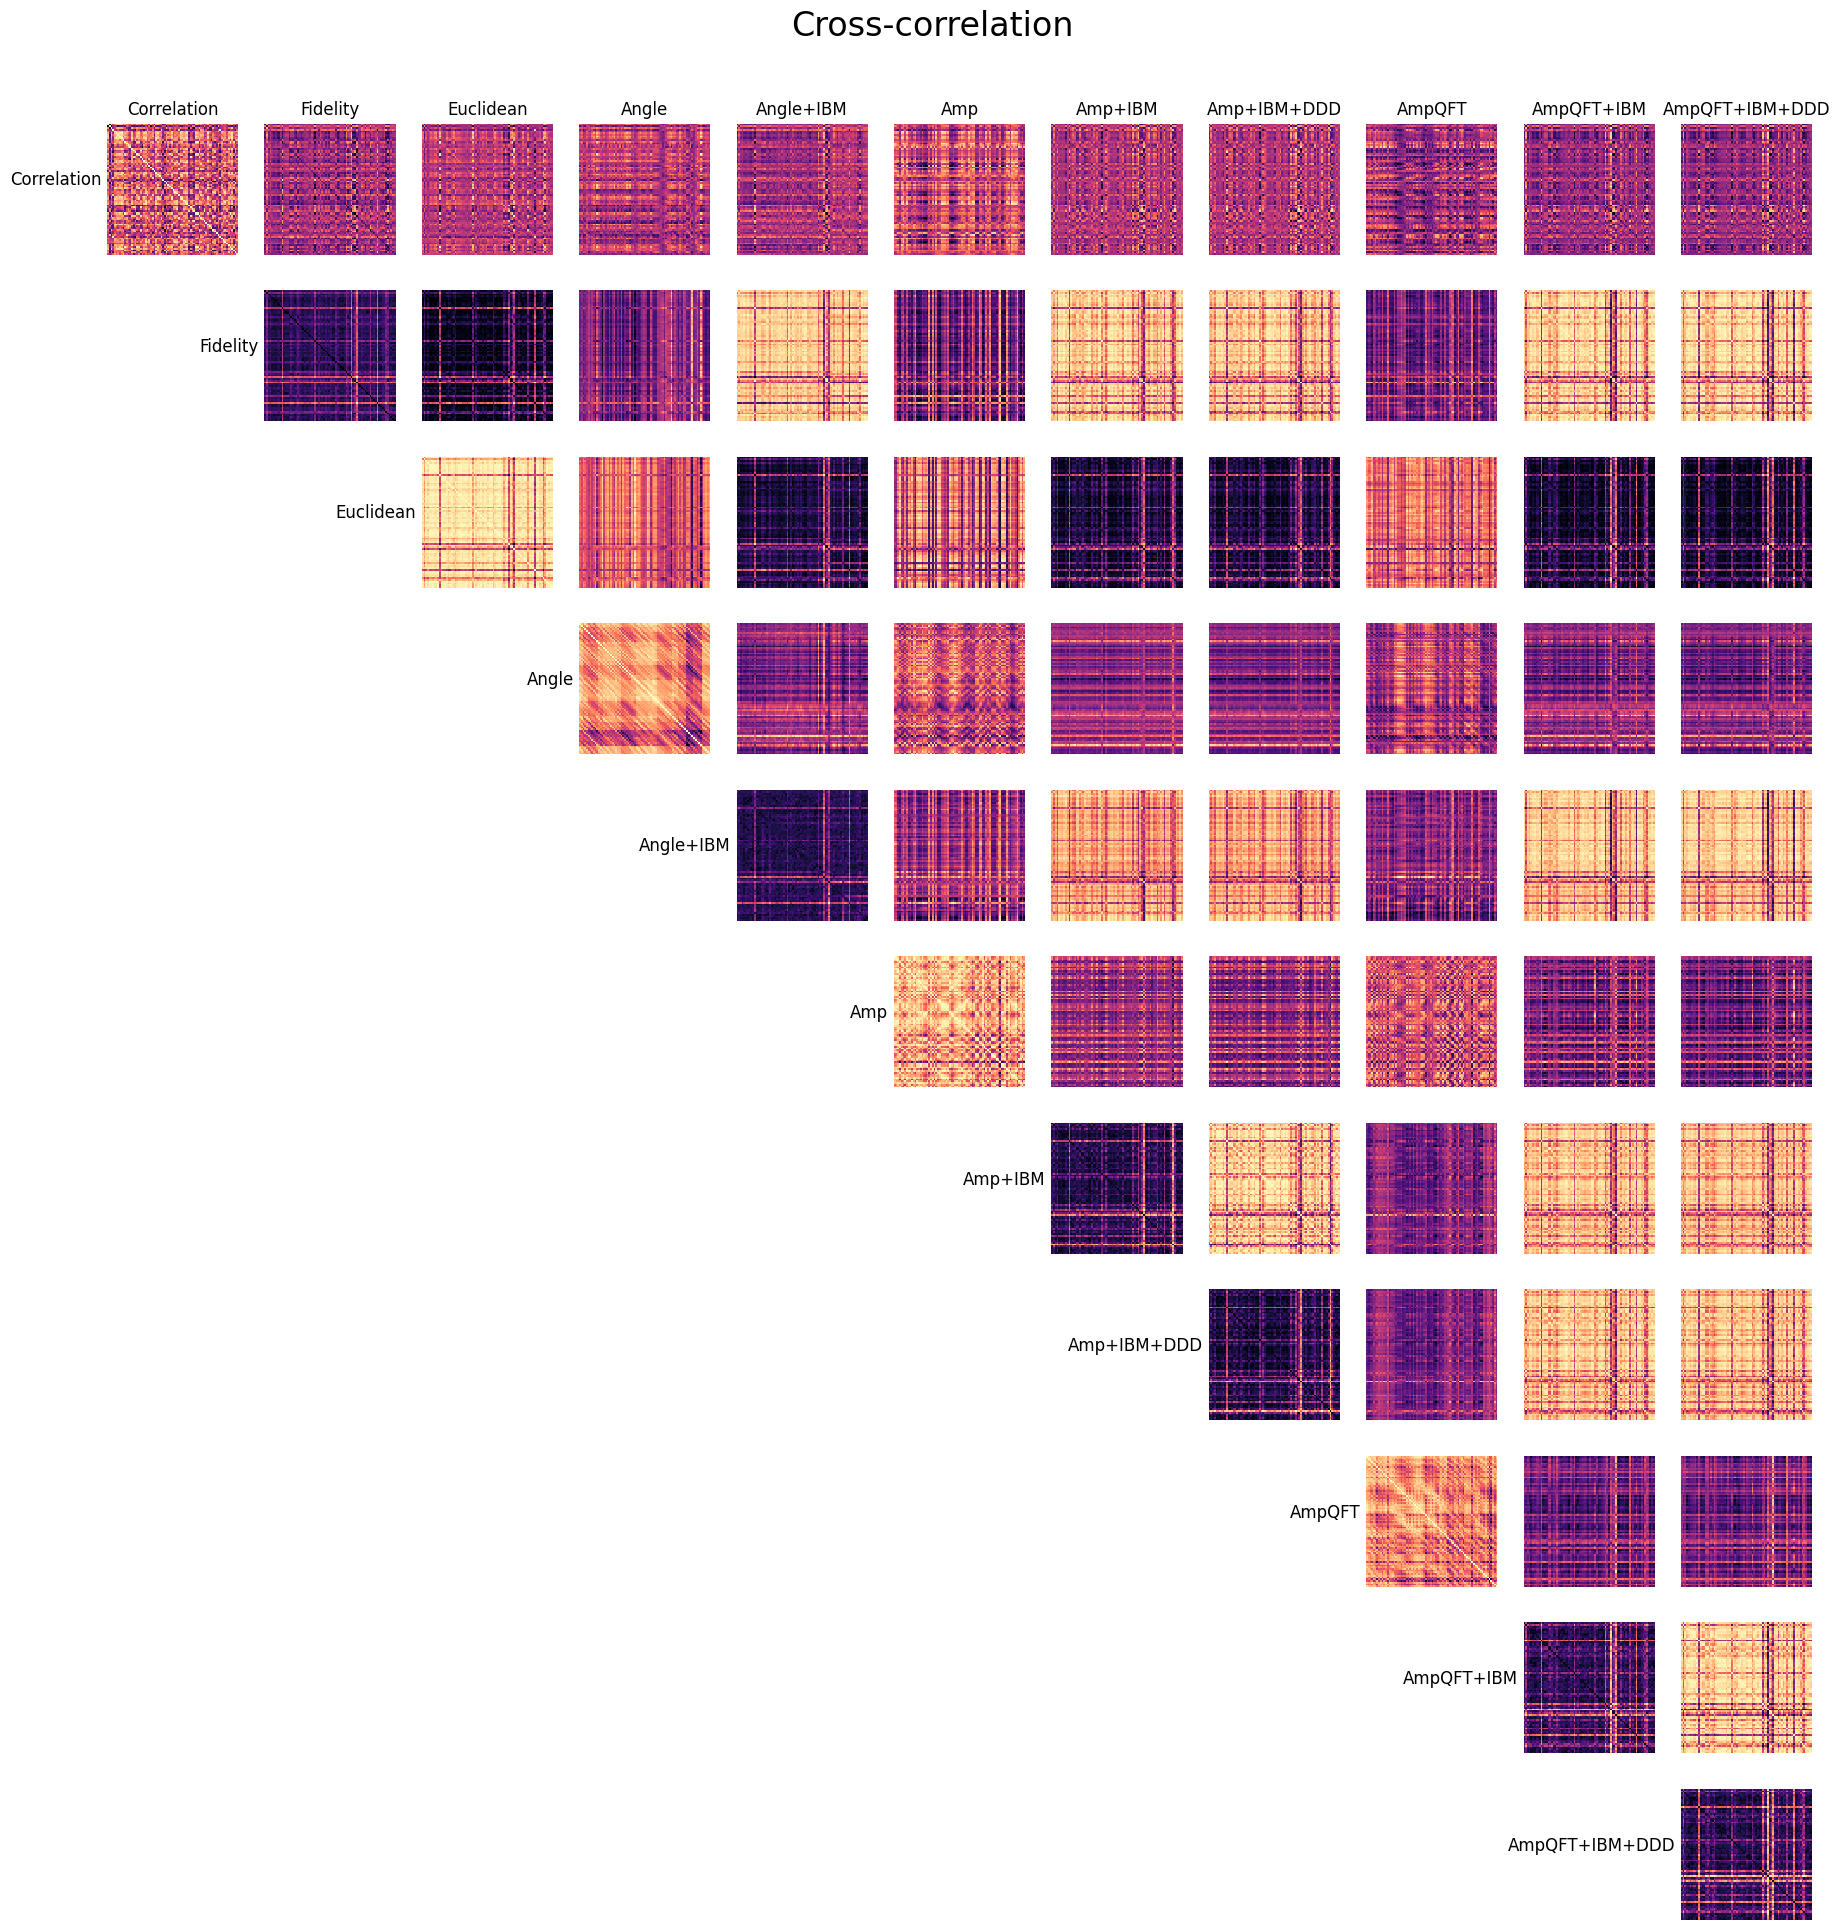

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Create sample matrices
matrices = [
    corrs_df,
    euclidean_distance_df,
    classical_fidelity_df,
    # euclidean_distance_ifft_df, # basically the same
    qf_matrix['ang'], qpu_ang,
    # qf_matrix['ang-qft'], # basically the same
    qf_matrix['amp'], qpu_amp, qpu_amd_ddd,
    qf_matrix['amp-qft'], qpu_amp_qft, qpu_amp_qft_ddd
]
N = len(matrices)
titles = [
    'Correlation',
    'Fidelity',
    'Euclidean',
    'Angle',
    'Angle+IBM',
    'Amp',
    'Amp+IBM',
    'Amp+IBM+DDD',
    'AmpQFT',
    'AmpQFT+IBM',
    'AmpQFT+IBM+DDD'
]

# Create a figure
fig = plt.figure(figsize=(N*2, N*2))

# Create a grid spec
gs = gridspec.GridSpec(N, N, wspace=0.2, hspace=0.2)

def replace_bottom_triangle_with_nan(matrix):
    new_matrix = matrix.copy()
    n = matrix.shape[0]
    mask = np.tril(np.ones((n, n), dtype=bool))
    new_matrix[mask] = None
    return new_matrix


# Plot original heatmaps on the main diagonal and correlation heatmaps
for i in range(N):
    for j in range(i, N):
        if i == j:
            # Plot original heatmaps on the main diagonal
            ax = fig.add_subplot(gs[i, j])
            upper_triangle_matrix = matrices[i]
            # upper_triangle_matrix = replace_bottom_triangle_with_nan(upper_triangle_matrix)  # to eliminate lower triangle
            sns.heatmap(upper_triangle_matrix, ax=ax, cbar=False, square=True, cmap='magma') #, vmin=0, vmax=1)

        elif i < j:
            # Plot correlation heatmaps in the upper triangle
            ax = fig.add_subplot(gs[i, j])
            corr = np.corrcoef(matrices[i], matrices[j])
            sns.heatmap(corr[:76, 76:], ax=ax, cbar=False, square=True, cmap='magma') #, vmin=0, vmax=1)

        # clear labels
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')

        if i == 0:
            ax.set_title(titles[j], fontsize=12)  # Set title for top row
        if i == j:
            ax.set_ylabel(titles[i], fontsize=12, rotation=0, ha='right')  # Set ylabel for left column

fig.suptitle('Cross-correlation', fontsize=24)
fig.subplots_adjust(top=0.93)  # move suptitle down
plt.tight_layout()

plt.savefig(FIGS + 'cross-correlation.png', dpi=300)
plt.show()


## heatmaps of main diagonal specifically

Just the main diagonal into 4 different plots for closer viewing


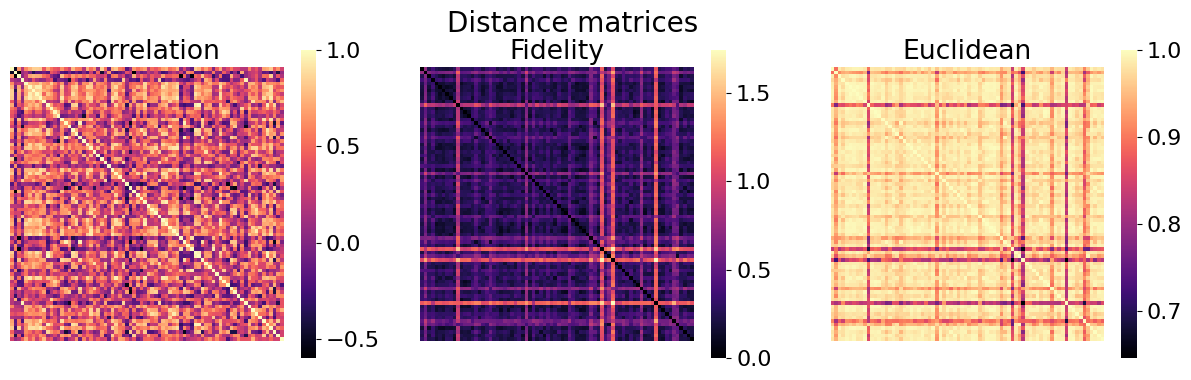

In [18]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for i in range(len(axes)):
    ax = axes[i]
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Distance matrices', fontsize=20)
plt.savefig(ENV['PWD'] + '/figures/correlation-classical.png', dpi=300)
plt.show()

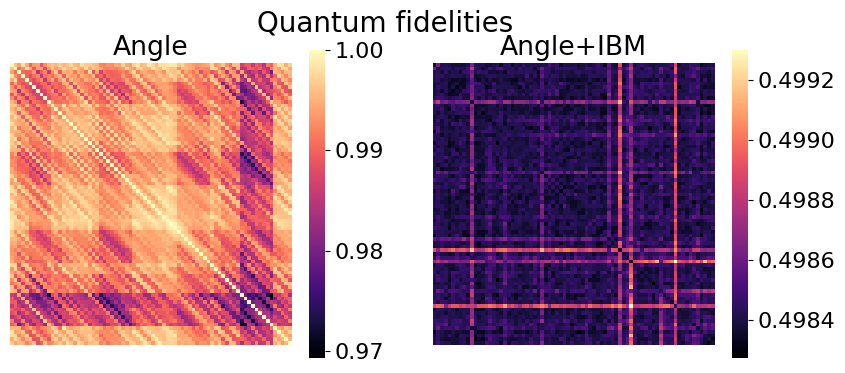

In [19]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()
for j in range(len(axes)):
    ax = axes[j]
    i = j+3
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Quantum fidelities', fontsize=20)
plt.savefig(ENV['PWD'] + '/figures/correlation-ang.png', dpi=300)
plt.show()

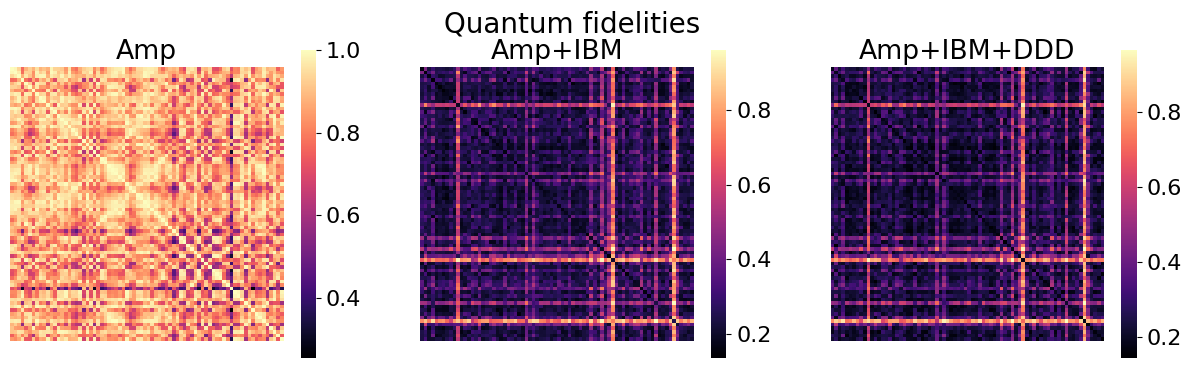

In [20]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for j in range(len(axes)):
    ax = axes[j]
    i = j+5
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Quantum fidelities', fontsize=20)
plt.savefig(ENV['PWD'] + '/figures/correlation-amp', dpi=300)
plt.show()

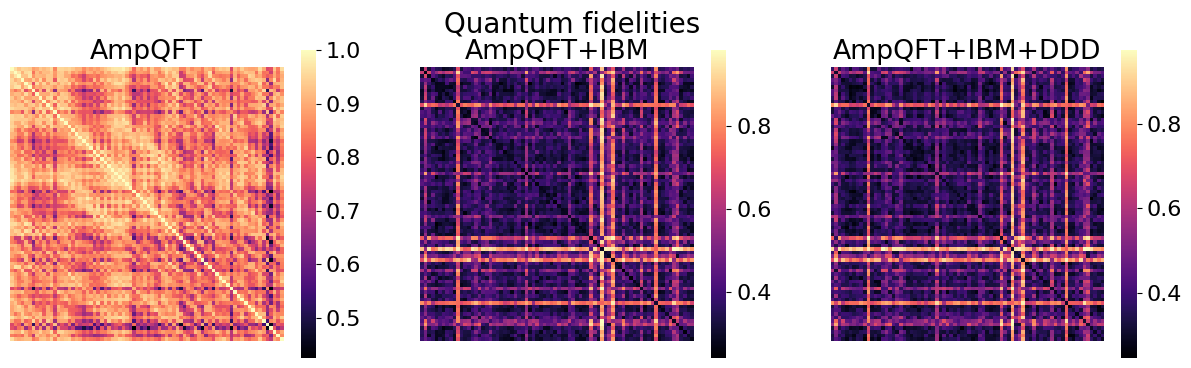

In [21]:
plt.rcParams['font.size'] = 16
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes = axes.flatten()
for j in range(len(axes)):
    ax = axes[j]
    i = j+8
    sns.heatmap(matrices[i], ax=ax, cmap='magma', square=True)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(titles[i])
plt.suptitle('Quantum fidelities', fontsize=20)

plt.savefig(ENV['PWD'] + '/figures/correlation-amp-qft', dpi=300)

plt.show()

# statistical testing
- the proper test for 2 distance matrices is actually Mantel's test.
- we can use this if we have *distance* matrices to measure the correlation (-1 to +1)
- https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
- says spearman method should be use when non-linearity is expected, which we use here
- as implemented in skbio, mantel's test requires the diagonals to be 0
- this means that we should invert state fidelity (1-fidelity) bc the middle diagonal is 1, not 0
- The diagonal for state fidelity is not exactly 0, but it's very close to 0 so we can use Mantel's test anyways

In [22]:
from skbio.stats.distance import mantel, pwmantel
# wrapping to fill diagonals to 0
def mantel_test(a, b):
    # a and b should be PD dataframes
    a_np = a.to_numpy() if type(a) is pd.DataFrame else a
    b_np = b.to_numpy() if type(b) is pd.DataFrame else b
    np.fill_diagonal(a_np, 0)  # in-place ops
    np.fill_diagonal(b_np, 0)
    return mantel(a_np, b_np, method='spearman', seed=0)

def pw_mantel_test(dfs, labels=None):
    # a and b should be PD dataframes
    dfs_np = [d.to_numpy() if type(d) is pd.DataFrame else d.copy() for d in dfs]
    for d in dfs_np:
        np.fill_diagonal(d, 0)
    return pwmantel(dfs_np, method='spearman', labels=labels, seed=0)

In [23]:
# not the same
labels = [
    'Correlation',
        'Euclidean',
        'Fidelity',
          'Angle',
          'Angle+IBM',
          'Amp',
          'Amp+IBM',
          'Amp+IBM+DDD',
          'Amp+QFT',
          'Amp+QFT+IBM',
          'Amp+QFT+IBM+DDD',
    ]
stat_result = pw_mantel_test(
    [
        corrs_df, # still works despite not being distances as we are comparing rank orders
        euclidean_distance_df,
        classical_fidelity_df,
        qf_matrix['ang'],
        qpu_ang,
        qf_matrix['amp'],
        qpu_amp,
        qpu_amd_ddd,
        qf_matrix['amp-qft'],
        qpu_amp_qft,
        qpu_amp_qft_ddd,
        # euclidean_distance_ifft_df,
    ],
    labels=labels
)
# rank correlation shows how correlated the ranks of data are
# Euclidean is almost identical to EiFFT
stat_result_table = stat_result[['statistic', 'p-value']]
stat_result_table

statistic  p-value
dm1         dm2                                
Correlation Euclidean        -0.487926    0.001
            Fidelity          0.493476    0.001
            Angle             0.032489    0.583
            Angle+IBM        -0.351531    0.001
            Amp               0.053165    0.234
            Amp+IBM          -0.333363    0.001
            Amp+IBM+DDD      -0.317744    0.001
            Amp+QFT           0.030473    0.514
            Amp+QFT+IBM      -0.429649    0.001
            Amp+QFT+IBM+DDD  -0.426339    0.001
Euclidean   Fidelity         -0.993824    0.001
            Angle            -0.116311    0.151
            Angle+IBM         0.711980    0.001
            Amp              -0.105529    0.058
            Amp+IBM           0.775658    0.001
            Amp+IBM+DDD       0.789896    0.001
            Amp+QFT          -0.145397    0.027
            Amp+QFT+IBM       0.879634    0.001
            Amp+QFT+IBM+DDD   0.883580    0.001
Fidelity    Angle             0.132667    0.108
            Angle+IBM        -0.701912    0.001
            Amp               0.099977    0.112
            Amp+IBM          -0.783226    0.001
            Amp+IBM+DDD      -0.797486    0.001
            Amp+QFT           0.140212    0.042
            Amp+QFT+IBM      -0.873035    0.001
            Amp+QFT+IBM+DDD  -0.880557    0.001
Angle       Angle+IBM        -0.145179    0.031
            Amp               0.057969    0.310
            Amp+IBM          -0.133687    0.083
            Amp+IBM+DDD      -0.142737    0.052
            Amp+QFT           0.038642    0.532
            Amp+QFT+IBM      -0.104128    0.164
            Amp+QFT+IBM+DDD  -0.109096    0.142
Angle+IBM   Amp              -0.077335    0.112
            Amp+IBM           0.587477    0.001
            Amp+IBM+DDD       0.603336    0.001
            Amp+QFT          -0.080500    0.158
            Amp+QFT+IBM       0.666022    0.001
            Amp+QFT+IBM+DDD   0.662984    0.001
Amp         Amp+IBM          -0.076912    0.139
            Amp+IBM+DDD      -0.089485    0.128
            Amp+QFT           0.349348    0.001
            Amp+QFT+IBM      -0.060441    0.282
            Amp+QFT+IBM+DDD  -0.069391    0.210
Amp+IBM     Amp+IBM+DDD       0.918820    0.001
            Amp+QFT          -0.129194    0.028
            Amp+QFT+IBM       0.745468    0.001
            Amp+QFT+IBM+DDD   0.758349    0.001
Amp+IBM+DDD Amp+QFT          -0.143257    0.021
            Amp+QFT+IBM       0.761468    0.001
            Amp+QFT+IBM+DDD   0.777172    0.001
Amp+QFT     Amp+QFT+IBM      -0.150170    0.015
            Amp+QFT+IBM+DDD  -0.150436    0.021
Amp+QFT+IBM Amp+QFT+IBM+DDD   0.904061    0.001

In [24]:
statistic_matrix = stat_result_table.reset_index().pivot_table(index='dm1', columns='dm2')['statistic']
# sort rows by number of NaNs
statistic_matrix = statistic_matrix.loc[statistic_matrix.isnull().sum(axis=1).sort_values(ascending=False).index]
# then sort columns
statistic_matrix = statistic_matrix[statistic_matrix.isnull().sum(axis=0).sort_values(ascending=False).index]
statistic_matrix

dm2,Euclidean,Fidelity,Angle,Angle+IBM,Amp,Amp+IBM,Amp+IBM+DDD,Amp+QFT,Amp+QFT+IBM,Amp+QFT+IBM+DDD
dm1,,,,,,,,,,
Amp+QFT+IBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904061
Amp+QFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.150170,-0.150436
Amp+IBM+DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.143257,0.761468,0.777172
Amp+IBM,NaN,NaN,NaN,NaN,NaN,NaN,0.918820,-0.129194,0.745468,0.758349
Amp,NaN,NaN,NaN,NaN,NaN,-0.076912,-0.089485,0.349348,-0.060441,-0.069391
Angle+IBM,NaN,NaN,NaN,NaN,-0.077335,0.587477,0.603336,-0.080500,0.666022,0.662984
Angle,NaN,NaN,NaN,-0.145179,0.057969,-0.133687,-0.142737,0.038642,-0.104128,-0.109096
Fidelity,NaN,NaN,0.132667,-0.701912,0.099977,-0.783226,-0.797486,0.140212,-0.873035,-0.880557
Euclidean,NaN,-0.993824,-0.116311,0.711980,-0.105529,0.775658,0.789896,-0.145397,0.879634,0.883580


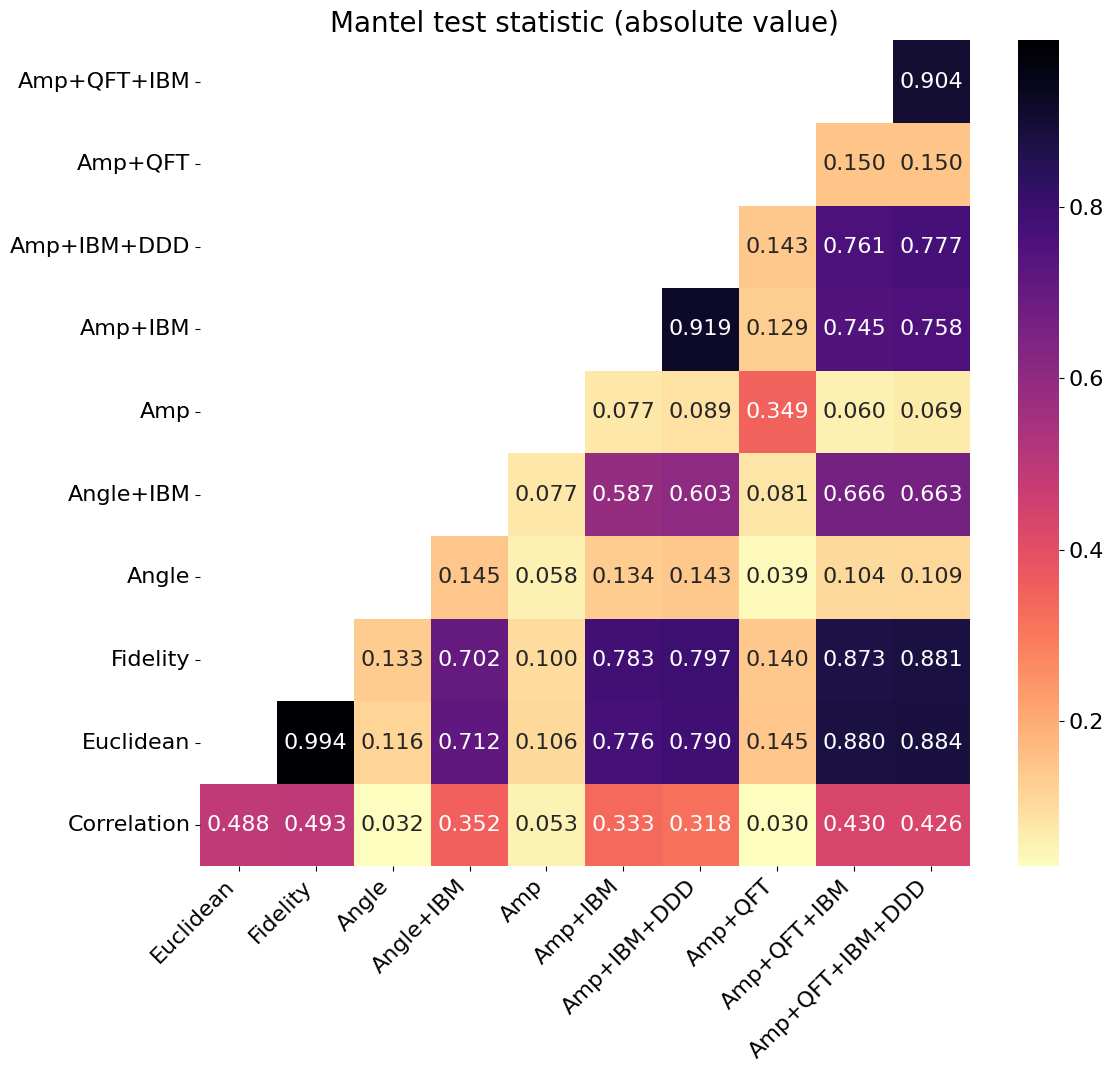

In [25]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 11))
sns.heatmap(np.abs(statistic_matrix), annot=True, cmap='magma_r', fmt='.3f')
plt.title("Mantel test statistic (absolute value)", fontsize=20)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/mantel-test.png', dpi=300)
plt.show()

In [26]:
pvalue_matrix = stat_result_table.reset_index().pivot_table(index='dm1', columns='dm2')['p-value']
# sort rows by number of NaNs
pvalue_matrix = pvalue_matrix.loc[pvalue_matrix.isnull().sum(axis=1).sort_values(ascending=False).index]
# then sort columns
pvalue_matrix = pvalue_matrix[pvalue_matrix.isnull().sum(axis=0).sort_values(ascending=False).index]
pvalue_matrix

dm2,Euclidean,Fidelity,Angle,Angle+IBM,Amp,Amp+IBM,Amp+IBM+DDD,Amp+QFT,Amp+QFT+IBM,Amp+QFT+IBM+DDD
dm1,,,,,,,,,,
Amp+QFT+IBM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001
Amp+QFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.015,0.021
Amp+IBM+DDD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021,0.001,0.001
Amp+IBM,NaN,NaN,NaN,NaN,NaN,NaN,0.001,0.028,0.001,0.001
Amp,NaN,NaN,NaN,NaN,NaN,0.139,0.128,0.001,0.282,0.210
Angle+IBM,NaN,NaN,NaN,NaN,0.112,0.001,0.001,0.158,0.001,0.001
Angle,NaN,NaN,NaN,0.031,0.310,0.083,0.052,0.532,0.164,0.142
Fidelity,NaN,NaN,0.108,0.001,0.112,0.001,0.001,0.042,0.001,0.001
Euclidean,NaN,0.001,0.151,0.001,0.058,0.001,0.001,0.027,0.001,0.001


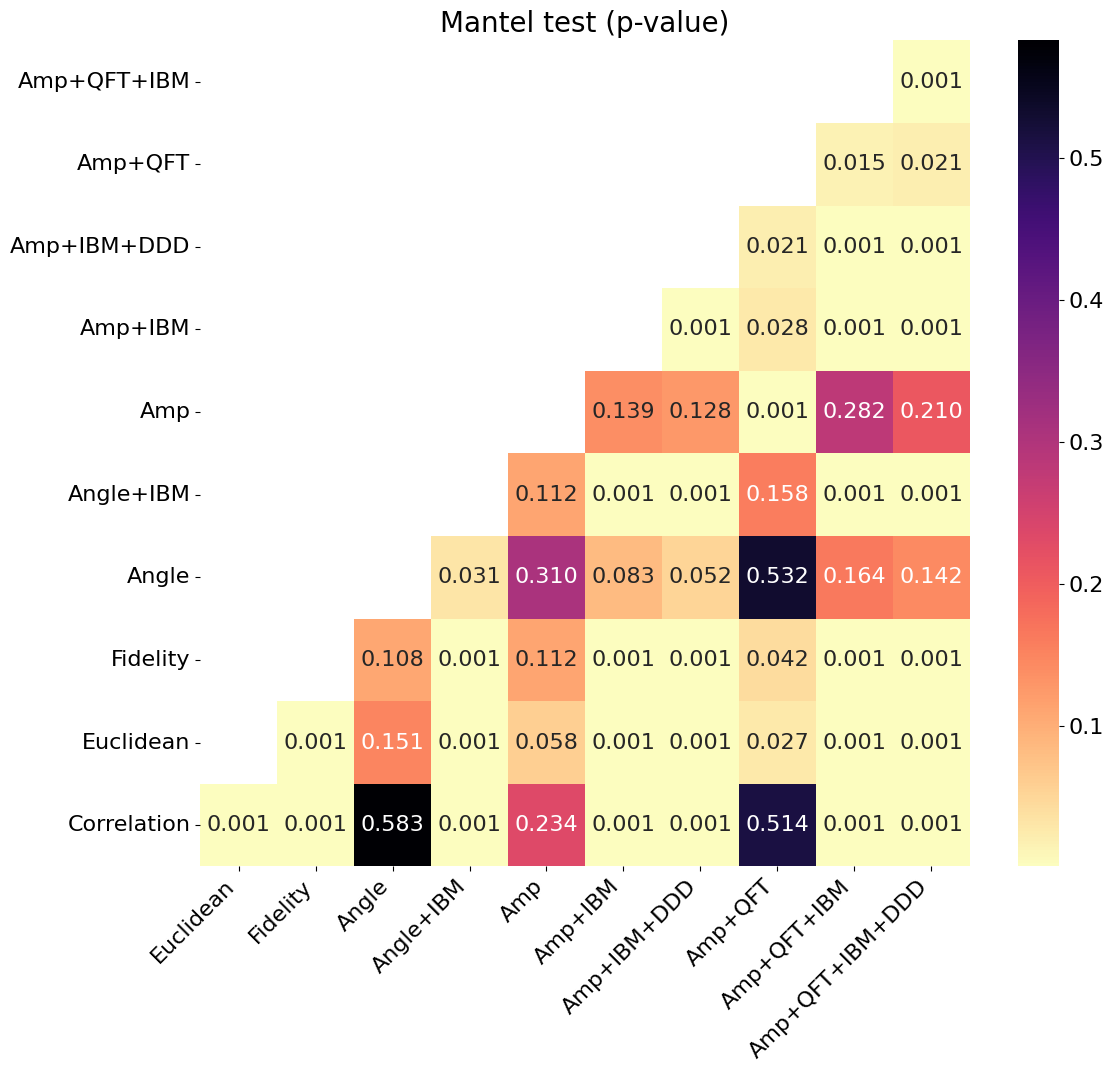

In [27]:
plt.rcParams['font.size'] = 16
fig, ax = plt.subplots(figsize=(12, 11))

sns.heatmap(pvalue_matrix, annot=True, cmap='magma_r', fmt='.3f')
plt.plot(size=(12, 10))
plt.title("Mantel test (p-value)", fontsize=20)
plt.xlabel(None)
plt.ylabel(None)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(ENV['PWD'] + '/figures/mantel-test-pvalue.png', dpi=300)
plt.show()